## Lihua Dong (ld457)
## Duo Sun (ds2324)
## Ziming Zeng (zz494)

In [1]:
import numpy as np
import pandas as pd
import scipy.linalg as sl
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import time
sns.set()
%matplotlib inline

At stage 1, we chose Amazon to analyze. However, we found that the best bid-ask spread of it was too large in this exchange. Thus, we changed our stock in stage 2. At this stage, We chose Microsoft (MSFT) to analyze. We first rerun the code of stage 1 to access the limit order flow for Microsoft, which is stored in the file 'msft.csv'.

Then we compute the best bid and best ask series for MSFT.

In [2]:
msft = pd.read_csv('msft.csv', index_col=0)

In [3]:
msft.head()

,order_id,order_size,order_type,price,side,symbol,time,standard_time
93343,IT1KTC0000NB,10,A,90.20,S,MSFT,28262586,7:51:02.586
93344,IT1KTC0000NB,10,X,90.20,NaN,MSFT,28262586,7:51:02.586
94035,IT1KTC0000NE,10,A,90.17,B,MSFT,28282188,7:51:22.188
94036,IT1KTC0000NE,10,X,90.17,NaN,MSFT,28282188,7:51:22.188
94078,IT1KTC0000NF,10,A,90.20,S,MSFT,28283945,7:51:23.945


In [4]:
%%time
bid_price = []
bid_id = []
bid_size = []
ask_price = []
ask_id = []
ask_size = []
best_bid = pd.Series(index = msft.index)
best_bid_vol = pd.Series(index = msft.index)
best_ask = pd.Series(index = msft.index)
best_ask_vol = pd.Series(index = msft.index)

for idx, order in msft.iterrows():
    
    order_type = order['order_type']
    order_id = order['order_id']
    price = order['price']
    size = order['order_size']
    
    if order_type == 'A':
        
        if order['side'] == 'B':
            bid_price.append(price)
            bid_id.append(order_id)
            bid_size.append(size)
        elif order['side'] == 'S':
            ask_price.append(price)
            ask_id.append(order_id)
            ask_size.append(size)
    
    elif order_type == 'E' or order_type == 'X':
        
        try:
            index = bid_id.index(order_id)
            side = 1
        except ValueError:
            index = ask_id.index(order_id)
            side = 0
            
        if side == 1:
            bid_size[index] -= size
            if bid_size[index] == 0:
                bid_price.pop(index)
                bid_id.pop(index)
                bid_size.pop(index) 
        else:
            ask_size[index] -= size
            if ask_size[index] == 0:
                ask_price.pop(index)
                ask_id.pop(index)
                ask_size.pop(index)
    
    if bid_price:
        best_bid[idx] = max(bid_price)
        volume = np.array(bid_size)[np.where(bid_price == np.max(bid_price))[0]].sum()
        if volume != 0:
            best_bid_vol[idx] = volume
    
    if ask_price:
        best_ask[idx] = min(ask_price)
        volume = np.array(ask_size)[np.where(ask_price == np.min(ask_price))[0]].sum()
        if volume != 0:
            best_ask_vol[idx] = volume

CPU times: user 1min 46s, sys: 558 ms, total: 1min 47s
Wall time: 1min 47s


## Compute the best bid and ask series for MSFT (minute resolution)

In [5]:
%%time
freq = '1min'
fmt = '%H:%M'
time_loc = -7

# If you want to use second resolution, uncomment the three lines below
# freq = '1s'
# fmt = '%H:%M:%S'
# time_loc = -4

order_time = msft['standard_time'].apply(lambda x: x[:time_loc])
time_range = pd.date_range(order_time.iloc[0], order_time.iloc[-1], freq=freq).time
order_time = pd.to_datetime(order_time, format=fmt).apply(lambda x: x.time())

best_bid_ask = pd.DataFrame({'time': order_time, 'best_bid': best_bid, 'best_bid_vol': best_bid_vol,
                             'best_ask': best_ask, 'best_ask_vol': best_ask_vol})
# best_bid_ask = best_bid_ask.groupby('time').last().fillna(-1)
best_bid_ask = best_bid_ask.groupby('time').apply(lambda x: x.iloc[-1])

best_bid_ask_df = pd.DataFrame(index = time_range, columns=['best_bid', 'best_bid_vol', 'best_ask', 'best_ask_vol'])
best_bid_ask_df.loc[best_bid_ask.index, 'best_bid'] = best_bid_ask['best_bid']
best_bid_ask_df.loc[best_bid_ask.index, 'best_bid_vol'] = best_bid_ask['best_bid_vol']
best_bid_ask_df.loc[best_bid_ask.index, 'best_ask'] = best_bid_ask['best_ask']
best_bid_ask_df.loc[best_bid_ask.index, 'best_ask_vol'] = best_bid_ask['best_ask_vol']
# best_bid_ask_df = best_bid_ask_df.fillna(method = 'ffill').replace(-1, np.nan)

best_bid_ask_df = best_bid_ask_df.loc[datetime.time(9, 30): datetime.time(16, 0)]
best_bid_ask_df.fillna(method='ffill', inplace=True)

CPU times: user 3.25 s, sys: 119 ms, total: 3.37 s
Wall time: 3.4 s


In [6]:
# Best bid and ask series for MSFT (minute resolution)
best_bid_ask_df.head()

,best_bid,best_bid_vol,best_ask,best_ask_vol
09:30:00,89.38,100.0,89.88,100.0
09:31:00,89.96,100.0,90.05,100.0
09:32:00,90.25,155.0,90.35,100.0
09:33:00,90.52,55.0,90.61,55.0
09:34:00,90.21,155.0,90.30,155.0


(array([88., 89., 90., 91., 92., 93., 94., 95.]),
 <a list of 8 Text yticklabel objects>)

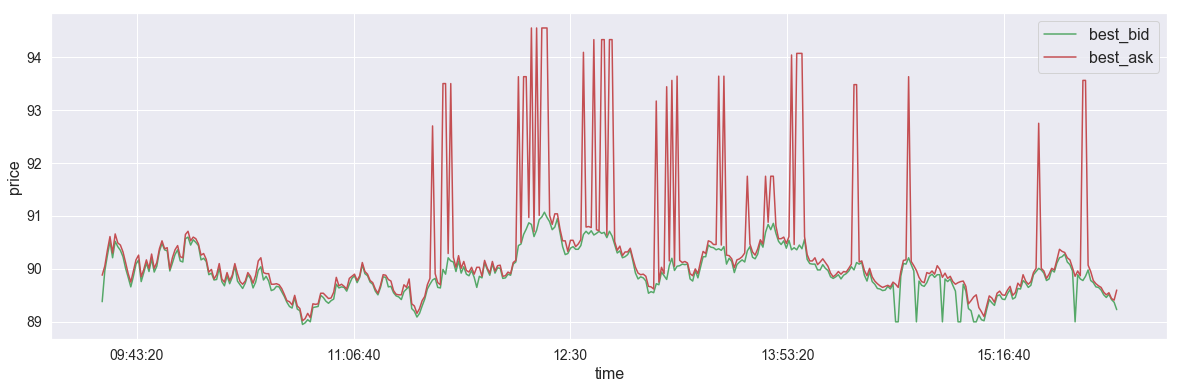

In [7]:
# Plot the Best bid and ask series for MSFT
best_bid_ask_df.loc[:,['best_bid', 'best_ask']].plot(figsize=(20,6), color = ['g', 'r'])
plt.legend(fontsize=16)
plt.xlabel('time', fontsize=16)
plt.ylabel('price', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

## Plot of the best bid volumes at each minute

<BarContainer object of 391 artists>

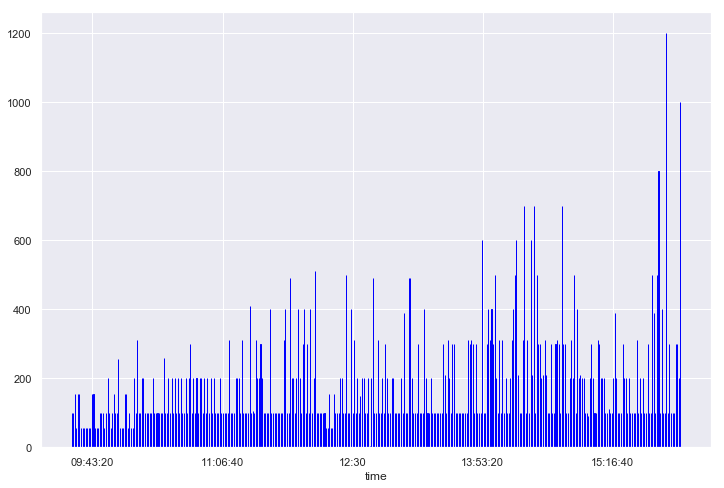

In [8]:
plt.figure(figsize=(12,8))
plt.bar(best_bid_ask_df.best_bid_vol.index, best_bid_ask_df.best_bid_vol, edgecolor='blue')

In order to compute the steady probabilities for the best bid volumes, we need to first compute the transition matrix for the best bid volumes. Then we calculate the eigvalues and eigenvectors for the matrix. The vector of steady probabilities is the eigenvector that corresponds to the largest eigenvalues. We also normalized that eigenvector by the sum of it in order to ensure the sum of the steady probabilities is 1. 

## Bid steady-state transition probabilities for the entire day

In [9]:
%%time

unique_bid_vol = best_bid_ask_df['best_bid_vol'].unique()
unique_bid_vol = np.append(unique_bid_vol, [0])
unique_bid_vol.sort()
bid_mat = pd.DataFrame(0, index=unique_bid_vol, columns=unique_bid_vol)

bid_vol_list = best_bid_ask_df.best_bid_vol
for i in range(len(bid_vol_list)-1):
    bid_mat.loc[bid_vol_list[i], bid_vol_list[i+1]] += 1
    
bid_mat.loc[0, bid_vol_list[0]] += 1
bid_mat.loc[bid_vol_list[-1], 0] += 1
bid_mat = bid_mat.div(bid_mat.sum(axis=1), axis=0)

CPU times: user 219 ms, sys: 31.5 ms, total: 251 ms
Wall time: 290 ms


In [10]:
eig_value, eig_vec, _ = sl.eig(bid_mat, left=True)
steady_prob = pd.DataFrame(np.real(eig_vec[:,eig_value.argmax()]), index=unique_bid_vol, columns=['steady state'])
steady_prob = steady_prob / steady_prob.sum()
steady_prob.sort_values('steady state', ascending=False)

,steady state
100.0,0.482143
200.0,0.178571
300.0,0.071429
55.0,0.058673
310.0,0.053571
400.0,0.030612
155.0,0.025510
500.0,0.017857
210.0,0.015306
490.0,0.010204


In [11]:
print('The best bid volume with largest steady probability:', steady_prob['steady state'].idxmax())

The best bid volume with largest steady probability: 100.0


## Bid steady-state transition probabilities from 10am-12pm

In [12]:
%%time
temp = best_bid_ask_df.loc[datetime.time(10, 0):datetime.time(12, 0)]
unique_bid_vol = temp['best_bid_vol'].unique()
# unique_bid_vol = np.append(unique_bid_vol, [0])
unique_bid_vol.sort()
bid_mat = pd.DataFrame(0, index=unique_bid_vol, columns=unique_bid_vol)

bid_vol_list = temp.best_bid_vol
for i in range(len(bid_vol_list)-1):
    bid_mat.loc[bid_vol_list[i], bid_vol_list[i+1]] += 1

# bid_mat.loc[0, bid_vol_list[0]] += 1
# bid_mat.loc[bid_vol_list[-1], 0] += 1
bid_mat = bid_mat.div(bid_mat.sum(axis=1), axis=0)


CPU times: user 42.1 ms, sys: 1.65 ms, total: 43.7 ms
Wall time: 46 ms


In [13]:
eig_value, eig_vec, _ = sl.eig(bid_mat, left=True)
steady_prob = pd.DataFrame(np.real(eig_vec[:,eig_value.argmax()]), index=unique_bid_vol, columns=['steady state'])
steady_prob = steady_prob / steady_prob.sum()
steady_prob.sort_values('steady state', ascending=False)

,steady state
100.0,0.568851
200.0,0.256818
310.0,0.043758
400.0,0.034688
55.0,0.026255
300.0,0.025873
155.0,0.008752
106.0,0.008752
259.0,0.008752
410.0,0.008752


In [14]:
print('The best bid volume with largest steady probability:', steady_prob['steady state'].idxmax())

The best bid volume with largest steady probability: 100.0


## Bid steady-state transition probabilities from 12pm-2pm

In [15]:
%%time
temp = best_bid_ask_df.loc[datetime.time(12, 0):datetime.time(14, 0)]
unique_bid_vol = temp['best_bid_vol'].unique()
# unique_bid_vol = np.append(unique_bid_vol, [0])
unique_bid_vol.sort()
bid_mat = pd.DataFrame(0, index=unique_bid_vol, columns=unique_bid_vol)

bid_vol_list = temp.best_bid_vol
for i in range(len(bid_vol_list)-1):
    bid_mat.loc[bid_vol_list[i], bid_vol_list[i+1]] += 1
    
# bid_mat.loc[0, bid_vol_list[0]] += 1
# bid_mat.loc[bid_vol_list[-1], 0] += 1
bid_mat = bid_mat.div(bid_mat.sum(axis=1), axis=0)

CPU times: user 41.5 ms, sys: 1.66 ms, total: 43.2 ms
Wall time: 43.6 ms


In [16]:
eig_value, eig_vec, _ = sl.eig(bid_mat, left=True)
steady_prob = pd.DataFrame(np.real(eig_vec[:,eig_value.argmax()]), index=unique_bid_vol, columns=['steady state'])
steady_prob = steady_prob / steady_prob.sum()
steady_prob.sort_values('steady state', ascending=False)

,steady state
100.0,0.541444
200.0,0.141399
300.0,0.091868
310.0,0.050443
400.0,0.042205
55.0,0.032815
490.0,0.024782
155.0,0.016407
210.0,0.009187
3.0,0.008318


In [17]:
print('The best bid volume with largest steady probability:', steady_prob['steady state'].idxmax())

The best bid volume with largest steady probability: 100.0


## Bid steady-state transition probabilities from 2pm-4pm

In [18]:
%%time
temp = best_bid_ask_df.loc[datetime.time(14, 0):datetime.time(16, 0)]
unique_bid_vol = temp['best_bid_vol'].unique()
unique_bid_vol = np.append(unique_bid_vol, [0])
unique_bid_vol.sort()
bid_mat = pd.DataFrame(0, index=unique_bid_vol, columns=unique_bid_vol)

bid_vol_list = temp.best_bid_vol
for i in range(len(bid_vol_list)-1):
    bid_mat.loc[bid_vol_list[i], bid_vol_list[i+1]] += 1
    
bid_mat.loc[0, bid_vol_list[0]] += 1
bid_mat.loc[bid_vol_list[-1], 0] += 1
bid_mat = bid_mat.div(bid_mat.sum(axis=1), axis=0)

CPU times: user 41.8 ms, sys: 1.59 ms, total: 43.3 ms
Wall time: 44.2 ms


In [19]:
eig_value, eig_vec, _ = sl.eig(bid_mat, left=True)
steady_prob = pd.DataFrame(np.real(eig_vec[:,eig_value.argmax()]), index=unique_bid_vol, columns=['steady state'])
steady_prob = steady_prob / steady_prob.sum()
steady_prob.sort_values('steady state', ascending=False)

,steady state
100.0,0.393443
200.0,0.180328
300.0,0.122951
310.0,0.081967
500.0,0.049180
210.0,0.040984
400.0,0.024590
700.0,0.024590
600.0,0.016393
390.0,0.016393


In [20]:
print('The best bid volume with largest steady probability:', steady_prob['steady state'].idxmax())

The best bid volume with largest steady probability: 100.0


## Summary for best bid volume steady probabilities

There are no deviations from one 2-hour block to next because the best bid volume with the largest steady probability is 100 for all three block and the entire day.

## We also compute the steady probabilities for best ask volumes

## Ask steady-state transition probabilities for the entire day

In [21]:
%%time
unique_ask_vol = best_bid_ask_df['best_ask_vol'].unique()
# unique_ask_vol = np.append(unique_ask_vol, [0])
unique_ask_vol.sort()
ask_mat = pd.DataFrame(0, index=unique_ask_vol, columns=unique_ask_vol)

ask_vol_list = best_bid_ask_df.best_ask_vol
for i in range(len(ask_vol_list)-1):
    ask_mat.loc[ask_vol_list[i], ask_vol_list[i+1]] += 1
    
# ask_mat.loc[0, ask_vol_list[0]] += 1
# ask_mat.loc[ask_vol_list[-1], 0] += 1
ask_mat = ask_mat.div(ask_mat.sum(axis=1), axis=0)

CPU times: user 115 ms, sys: 2.51 ms, total: 118 ms
Wall time: 121 ms


In [22]:
eig_value, eig_vec, _ = sl.eig(ask_mat, left=True)
steady_prob = pd.DataFrame(np.real(eig_vec[:,eig_value.argmax()]), index=unique_ask_vol, columns=['steady state'])
steady_prob = steady_prob / steady_prob.sum()
steady_prob.sort_values('steady state', ascending=False)

,steady state
100.0,0.553846
200.0,0.156410
300.0,0.061538
310.0,0.051282
55.0,0.046154
400.0,0.023077
159.0,0.017949
210.0,0.015385
500.0,0.010256
410.0,0.007692


In [23]:
print('The best ask volume with largest steady probability:', steady_prob['steady state'].idxmax())

The best ask volume with largest steady probability: 100.0


## Ask steady-state transition probabilities from 10am-12pm

In [24]:
%%time
temp = best_bid_ask_df.loc[datetime.time(10, 0):datetime.time(12, 0)]
unique_ask_vol = temp['best_ask_vol'].unique()
unique_ask_vol.sort()
ask_mat = pd.DataFrame(0, index=unique_ask_vol, columns=unique_ask_vol)

ask_vol_list = temp.best_ask_vol
for i in range(len(ask_vol_list)-1):
    ask_mat.loc[ask_vol_list[i], ask_vol_list[i+1]] += 1

ask_mat = ask_mat.div(ask_mat.sum(axis=1), axis=0)

CPU times: user 41.3 ms, sys: 1.45 ms, total: 42.8 ms
Wall time: 45.9 ms


In [25]:
eig_value, eig_vec, _ = sl.eig(ask_mat, left=True)
steady_prob = pd.DataFrame(np.real(eig_vec[:,eig_value.argmax()]), index=unique_ask_vol, columns=['steady state'])
steady_prob = steady_prob / steady_prob.sum()
steady_prob.sort_values('steady state', ascending=False)

,steady state
100.0,0.502664
200.0,0.219829
159.0,0.052120
300.0,0.044012
55.0,0.040537
310.0,0.033356
90.0,0.025365
410.0,0.024322
53.0,0.016215
259.0,0.008455


In [26]:
print('The best ask volume with largest steady probability:', steady_prob['steady state'].idxmax())

The best ask volume with largest steady probability: 100.0


## Ask steady-state transition probabilities from 12pm-14pm

In [27]:
%%time
temp = best_bid_ask_df.loc[datetime.time(12, 0):datetime.time(14, 0)]
unique_ask_vol = temp['best_ask_vol'].unique()
unique_ask_vol.sort()
ask_mat = pd.DataFrame(0, index=unique_ask_vol, columns=unique_ask_vol)

ask_vol_list = temp.best_ask_vol
for i in range(len(ask_vol_list)-1):
    ask_mat.loc[ask_vol_list[i], ask_vol_list[i+1]] += 1

ask_mat = ask_mat.div(ask_mat.sum(axis=1), axis=0)

CPU times: user 42.4 ms, sys: 1.82 ms, total: 44.2 ms
Wall time: 45.3 ms


In [28]:
eig_value, eig_vec, _ = sl.eig(ask_mat, left=True)
steady_prob = pd.DataFrame(np.real(eig_vec[:,eig_value.argmax()]), index=unique_ask_vol, columns=['steady state'])
steady_prob = steady_prob / steady_prob.sum()
steady_prob.sort_values('steady state', ascending=False)

,steady state
100.0,0.720029
200.0,0.139124
310.0,0.041996
300.0,0.033022
210.0,0.025413
472.0,0.008471
500.0,0.008471
272.0,0.008471
510.0,0.008399
38.0,0.006604


In [29]:
print('The best ask volume with largest steady probability:', steady_prob['steady state'].idxmax())

The best ask volume with largest steady probability: 100.0


## Ask steady-state transition probabilities from 14pm-16pm

In [30]:
%%time
temp = best_bid_ask_df.loc[datetime.time(14, 0):datetime.time(16, 0)]
unique_ask_vol = temp['best_ask_vol'].unique()

unique_ask_vol.sort()
ask_mat = pd.DataFrame(0, index=unique_ask_vol, columns=unique_ask_vol)

ask_vol_list = temp.best_ask_vol
for i in range(len(ask_vol_list)-1):
    ask_mat.loc[ask_vol_list[i], ask_vol_list[i+1]] += 1

ask_mat = ask_mat.div(ask_mat.sum(axis=1), axis=0)

CPU times: user 45.1 ms, sys: 1.75 ms, total: 46.9 ms
Wall time: 49.5 ms


In [31]:
eig_value, eig_vec, _ = sl.eig(ask_mat, left=True)
steady_prob = pd.DataFrame(np.real(eig_vec[:,eig_value.argmax()]), index=unique_ask_vol, columns=['steady state'])
steady_prob = steady_prob / steady_prob.sum()
steady_prob.sort_values('steady state', ascending=False)

,steady state
100.0,0.508333
300.0,0.125000
200.0,0.125000
310.0,0.091667
400.0,0.058333
210.0,0.016667
500.0,0.016667
370.0,0.008333
110.0,0.008333
1700.0,0.008333


In [32]:
print('The best ask volume with largest steady probability:', steady_prob['steady state'].idxmax())

The best ask volume with largest steady probability: 100.0


## Summary for best ask volume steady probabilities

There are also no deviations from one 2-hour block to next because the best ask volume with the largest steady probability is 100 for all three block and the entire day.